## 목표
유료 구독 전환 여부 판단

진행 방향

* 어떤 변수가 유료구독 전환 여부를 판단할 때 필요할까

* 먼저 액션과 구독여부로 로지스틱 회귀를 돌릴 경우, accuracy는 높게 나왔으나 낮은 recall, f1-score가 나왔음.


* 유의미한 변수를 추가하고 선별 후 cut off 값을 변경하여 로지스틱회귀를 돌렸을때</br>높은 accuracy와 recall, f1-score 값을 얻는 것이 목표</br>
* 처음 스케일러를 사용하였으나 결과값이 무의미하여 데이터 원본을 사용함

In [1]:
import pandas as pd
import numpy as np
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize 
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('./user_action_10days.csv')
# 파일 읽기

In [3]:
df=df.fillna('')
# 결측치를 공백으로 제거

In [4]:
df['continuous']=0
# 연속으로 들었는지 확인하는 변수를 만들기 위해 0 값을 넣어 continuous열 생성

In [5]:
for i in df.index:
    if (len(df.iloc[i,1])!=0) & (len(df.iloc[i,2])!=0)|(len(df.iloc[i,2])!=0) & (len(df.iloc[i,3])!=0)|(len(df.iloc[i,3])!=0) & (len(df.iloc[i,4])!=0)|(len(df.iloc[i,4])!=0) & (len(df.iloc[i,5])!=0)|(len(df.iloc[i,5])!=0) & (len(df.iloc[i,6])!=0)|(len(df.iloc[i,6])!=0) & (len(df.iloc[i,7])!=0)|(len(df.iloc[i,7])!=0) & (len(df.iloc[i,8])!=0)|(len(df.iloc[i,8])!=0) & (len(df.iloc[i,9])!=0)|(len(df.iloc[i,9])!=0) & (len(df.iloc[i,10])!=0):
        df['continuous'][i]=1
    else : df['continuous'][i]=0
# day1 ,2 혹은 day 2,3 혹은 day 3,4 ... 연속으로 들은 접속 기록이 있으면 1 없으면 0

In [6]:
df.drop(df[(df['day1'] =='') & (df['day2'] == '')& (df['day3'] == '')& (df['day4'] == '')& (df['day5'] == '')& (df['day6'] == '')& (df['day7'] == '')& (df['day8'] == '')& (df['day9'] == '')& (df['day10'] == '')].index, inplace=True)
# day1 부터 day10까지 아무런 값이 없는 행 삭제

In [7]:
df=df.replace('','NA')
# 그후 결측치가 있는 셀을 파악하기 위해 값을 NA 로 변경

In [8]:
list1=[]
for i in df.index:
    list1.append(df.iloc[i,1]+df.iloc[i,2]+df.iloc[i,3]+df.iloc[i,4]+df.iloc[i,5]+df.iloc[i,6]+df.iloc[i,7]+df.iloc[i,8]+df.iloc[i,9]+df.iloc[i,10])
# day 1 부터 day 10까지의 행동들을 모두 더함 (NA 값 포함)

In [9]:
df['sum']=list1
# 다 더한 값을 SUM 열에 추가해줌

In [10]:
list2=[]
for i in df.index:
    list2.append(df['sum'][i].count('NA'))
# 각각 결석 횟수 (수업을 하나도 듣지 않은 날)을 파악하기 위해 NA 값을 카운트함

In [11]:
df['결석횟수']=list2
# 결석 횟수 열을 생성해줌

In [12]:
df=df.replace('NA','')
# 결석 횟수를 파악했으니 NA값을 빈칸으로 변경

In [13]:
all_letters=df['day1'].str.cat()
action_list= list(set(list(all_letters)))
# 각 행동별 갯수를 파악하기 위해 action list 생성

In [14]:
for act in action_list:
    col_name=act+"_cnt"
    df[col_name]=df['sum'].apply(lambda x: x.count(act))

## 최종적으로 사용할 데이터
* 구독 여부, 연속 출석 여부, 결석 횟수, 각 행동별 카운트

In [15]:
df.iloc[:, [11,12,14,15,16,17,18,19,20,21,22,23,24]]

,subscribe,continuous,결석횟수,F_cnt,I_cnt,S_cnt,L_cnt,E_cnt,M_cnt,H_cnt,K_cnt,J_cnt,G_cnt
0,0,1,5,30,1,86,12,33,50,1,26,47,1
1,0,0,9,0,0,0,0,1,0,0,0,0,0
2,0,0,9,2,0,14,0,2,9,0,7,2,0
3,0,1,5,15,28,0,20,21,14,0,6,66,4
4,0,1,4,20,1,102,6,19,62,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,0,0,9,2,0,6,0,4,5,0,1,0,0
4161,0,0,9,0,0,1,0,0,0,0,0,0,0
4162,0,0,9,4,0,13,1,4,10,0,0,1,0
4163,0,0,9,9,3,15,0,10,9,1,0,1,1


In [16]:
X = df.iloc[:, [12,14,15,16,17,18,19,20,21,22,23,24]].values
Y = df.iloc[:, 11].values

In [17]:
model = GLM(Y,X,family=Binomial())
results = model.fit()
# 변수별 회귀 계수 및 p-value 확인을 위해 GLM (일반화 선형모형) 함수 사용 반응변수가 이항분포이므로 family=Binomial 사용

In [18]:
results.summary() 
# 이제 여기서 필요한 변수를 뽑기 위해 후진제거법 사용 (모든 변수를 다 넣어서 AIC 확인 후 변수를 삭제해가며 낮은 AIC가 나올때까지 반복)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4165
Model:                            GLM   Df Residuals:                     4153
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1666.7
Date:                Fri, 24 Feb 2023   Deviance:                       3333.3
Time:                        17:24:16   Pearson chi2:                 4.10e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2416
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6052      0.122      4.946      0.000       0.365       0.845
x2            -0.4306      0.017    -25.567      0.000      -0.464      -0.398
x3            -0.0090      0.007     -1.255      0.209      -0.023       0.005
x4             0.0029      0.007      0.429      0.668      -0.010       0.016
x5            -0.0037      0.002     -2.164      0.030      -0.007      -0.000
x6            -0.0012      0.001     -0.998      0.318      -0.003       0.001
x7             0.0057      0.007      0.829      0.407      -0.008       0.019
x8             0.0125      0.003      4.409      0.000       0.007       0.018
x9             0.0201      0.020      0.991      0.322      -0.020       0.060
x10            0.0009      0.000      1.928      0.054   -1.49e-05       0.002
x11           -0.0015      0.001     -1.411      0.158      -0.004       0.001
x12           -0.0179      0.019     -0.924      0.356      -0.056       0.020
==============================================================================
"""

## Pseudo R-squ(R제곱)
독립변수가 종속변수를 얼마나 잘 설명하는지 나타냄 (x,y 사이의 관계)

## Log-Likelihood
어떤 모델과 데이터가 주어졌을 때, 이 모델이 데이터를 얼마나 잘 설명하는지를 수치화 할 수 있는 척도 (모델과 데이터 사이의 관계)

## Deviance: 2[L1-L0]
조화모형과 독립모형 라이클리 차이(이탈도)
L1= 대립가설(복잡모형) 라이클리후드
L0= 귀무가설(간단모형) 라이클리후드

Deviance는 카이제곱 분포를 기각역으로 한다. 이탈도(deviance ~ x^2)
H0: 모형이 맞음 변수가 연관성 없다. 

## AIC: -2(log-likelihood - number of parameter)

Likelihood(우도; 가능도)란? 어떤 모델(파라미터;확률분포)과 데이터가 주어졌을 때, 이 모델이 데이터를 얼마나 잘 설명하는지? 수치화 할 수 있는 척도이다.

AIC는 **로그가능도함수 값이 높으면 가산점**을 주고 모형에 사용된 **모수가 많으면 패널티**를 주는 형식으로 만들어진 척도로 작으면 작을수록 바람직한 모형이라고 판단한다. **AIC가 작을 수록 좋은 모형**이라고 할 수 있다. </br></br></br>




예시) 2개의 모수를 이용한 모형의 로그가능도함수 값이-16 </br>
4개의 모수만을 이용한 모형의 로그가능도함수 값은 -15</br>
각 모형의 AIC는 각각 36과 38.

비록 로그가능도함수 값은 두 번째 모형이 더 컸지만 모형에 사용된 모수가 더 많아 첫 번째 모형에 비해 바람직하지 않다는 판단을 할 수 있다.

# AIC를 이용하여 후진제거법 실시

### 후진제거법 in R studio
``` python
#fit three models
model1 <- glm(mpg ~ disp + hp + wt + qsec, data = mtcars)
model2 <- glm(mpg ~ disp + qsec, data = mtcars)
model3 <- glm(mpg ~ disp + wt, data = mtcars)


library(AICcmodavg)

#define list of models
models <- list(model1, model2, model3)

#specify model names
mod.names <- c('model1', 'model2', 'model3')

#calculate AIC of each model
aictab(cand.set = models, modnames = mod.names)

Model selection based on AIC:

             AIC   
model1      162.43
model2      165.65
model3      173.32

```

위와 같은 방법으로 AIC값 구함.
처음 모든 변수를 선택하여 AIC값을 구한 후 위 결과 값에서 p-value가 낮은 변수부터 제거하여 AIC 값 구함.
AIC 값이 낮아지다가 다시 올라갈때까지 제거하는 **후진제거법** 사용

['E_cnt', 'F_cnt', 'G_cnt', 'H_cnt', 'J_cnt', 'K_cnt', 'L_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수']

['E_cnt', 'F_cnt', 'H_cnt', 'J_cnt', 'K_cnt', 'L_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수'] 

['E_cnt', 'F_cnt', 'J_cnt', 'K_cnt', 'L_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수'] 

['F_cnt', 'J_cnt', 'K_cnt', 'L_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수']

['F_cnt', 'J_cnt', 'K_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수']  -> **aic = 3334.380**

['J_cnt', 'K_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수']


**aic가 계속 감소**하다가 **6번에서 다시 증가**. 그러므로 **5번 선택**함

In [19]:
for_vif=df.loc[:, ['F_cnt', 'J_cnt', 'K_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수']]
for_vif
# 위에서 후진제거법을 이용하여 찾는 변수들 중 다중공선성 확인하기

,F_cnt,J_cnt,K_cnt,M_cnt,S_cnt,continuous,결석횟수
0,30,47,26,50,86,1,5
1,0,0,0,0,0,0,9
2,2,2,7,9,14,0,9
3,15,66,6,14,0,1,5
4,20,3,0,62,102,1,4
...,...,...,...,...,...,...,...
4160,2,0,1,5,6,0,9
4161,0,0,0,0,1,0,9
4162,4,1,0,10,13,0,9
4163,9,1,0,9,15,0,9


### 다중공선성

* 독립변수의 P값(P-value)이 커서 개별 인자들이 유의하지 않는 경우가 있다. 이런 경우 독립변수(X)들 간에 높은 상관관계가 있다고 의심된다.
* 독립변수들간의 상관계수를 구한다.
* 분산팽창요인(VIF, Variance Inflation Factor)을 구하여 이 값이 10을 넘는다면 보통 다중공선성의 문제가 있다.

In [20]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(for_vif.values, i) for i in range(for_vif.shape[1])]
vif["features"] = for_vif.columns
vif 

# M_cnt 와 S_cnt 사이 다중공선성이 있다고 판단됨.

,VIF Factor,features
0,7.676533,F_cnt
1,1.239030,J_cnt
2,1.256789,K_cnt
3,19.005495,M_cnt
4,20.975598,S_cnt
5,3.564565,continuous
6,1.656786,결석횟수


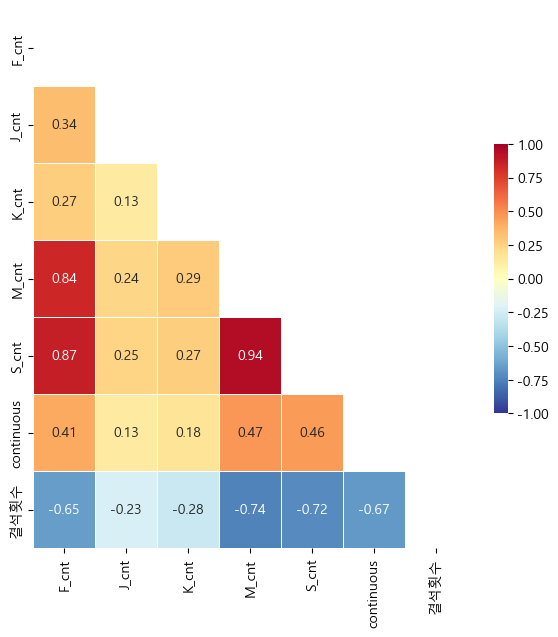

In [21]:
for_heatmap = for_vif.corr()
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots( figsize=(7,7) )

mask = np.zeros_like(for_heatmap, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(for_heatmap, 
            cmap = 'RdYlBu_r', 
            
            annot = True,  
            mask=mask,     
            linewidths=.5,  
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1  
           )  
plt.show()

다중공선성이 10이 넘는 변수 = M_cnt(19.005495) S_cnt(20.975598)

히트맵을 그려보고 M_cnt는 S_cnt와 강한 상관관계를 보이므로 S_cnt만 삭제 후 M_cnt는 사용하기로 결정

In [22]:
X = df.loc[:, ['F_cnt', 'J_cnt', 'K_cnt', 'M_cnt', 'S_cnt', 'continuous', '결석횟수']].values
Y = df.iloc[:, 11].values 

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [24]:
classifer = LogisticRegression()
classifer.fit(X_train, Y_train)

LogisticRegression()

In [25]:
Y_pred = classifer.predict(X_test)

In [26]:
accuracy_score(Y_test, Y_pred)

0.8451380552220888

In [27]:
cm=confusion_matrix(Y_test,classifer.predict(X_test))
cm

array([[614,  38],
       [ 91,  90]], dtype=int64)

In [28]:
cmtx = pd.DataFrame(
    confusion_matrix(Y_test, Y_pred, labels = [1, 0]),
    index = ['true:subscribe(1)', 'true:subscribe(0)'],
    columns = ['pred:subscribe(1)', 'pred:subscribe(0)']
)
cmtx

,pred:subscribe(1),pred:subscribe(0)
true:subscribe(1),90,91
true:subscribe(0),38,614


In [29]:
precision_recall_fscore_support(Y_test,Y_pred, average='binary')

(0.703125, 0.4972375690607735, 0.5825242718446602, None)

In [30]:
prob1=classifer.predict_proba(X_test) 

In [31]:
def objective_func(cutoff):
    list1=[]
    for i in range(len(prob1)):
        if prob1[i][1]>cutoff:
            list1.append(1)
        else:
            list1.append(0)
    return 1-(accuracy_score(Y_test, list1))

In [32]:
res = minimize(objective_func, 1, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.217287
         Iterations: 24
         Function evaluations: 71


Text(0, 0.5, '1-accuracy')

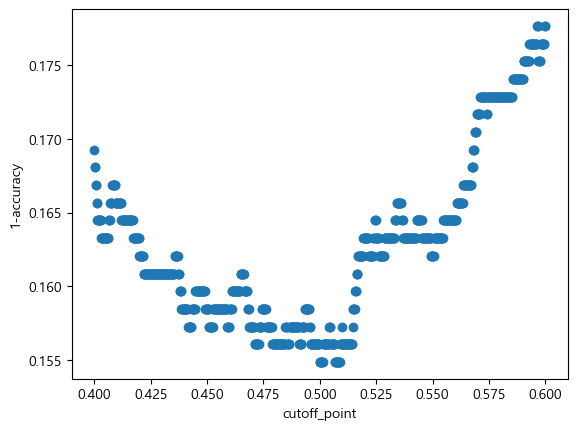

In [33]:
cutoff_points = np.linspace(0.4, 0.6, 1000)
accuracy_inversed_results = [objective_func(cutoff) for cutoff in cutoff_points]

plt.scatter(x=cutoff_points, y=accuracy_inversed_results)
plt.xlabel("cutoff_point")
plt.ylabel("1-accuracy")

In [34]:
for i in range(10000,0,-1):
    a=i*0.0001
    list1=[]
    list2=[]
    for j in range(len(prob1)):
        if prob1[j][1]>a:
            list1.append(1)
        else:
            list1.append(0)
            
    print(accuracy_score(Y_test, list1),a)
    # 각 cut-off별 accuracy 값 파악 
    # cut-off는 1부터 0.0001 단위로 0까지 하락
    # 왼쪽 accuracy 오른쪽 cut-off 값

0.7827130852340937 1.0
0.7827130852340937 0.9999
0.7827130852340937 0.9998
0.7827130852340937 0.9997
0.7827130852340937 0.9996
0.7827130852340937 0.9995
0.7827130852340937 0.9994000000000001
0.7827130852340937 0.9993000000000001
0.7827130852340937 0.9992000000000001
0.7827130852340937 0.9991000000000001
0.7827130852340937 0.999
0.7827130852340937 0.9989
0.7827130852340937 0.9988
0.7827130852340937 0.9987
0.7827130852340937 0.9986
0.7827130852340937 0.9985
0.7827130852340937 0.9984000000000001
0.7827130852340937 0.9983000000000001
0.7827130852340937 0.9982000000000001
0.7827130852340937 0.9981000000000001
0.7827130852340937 0.998
0.7827130852340937 0.9979
0.7827130852340937 0.9978
0.7827130852340937 0.9977
0.7827130852340937 0.9976
0.7827130852340937 0.9975
0.7827130852340937 0.9974000000000001
0.7827130852340937 0.9973000000000001
0.7827130852340937 0.9972000000000001
0.7827130852340937 0.9971000000000001
0.7827130852340937 0.997
0.7827130852340937 0.9969
0.7827130852340937 0.9968
0.78

0.7827130852340937 0.9433
0.7827130852340937 0.9432
0.7827130852340937 0.9431
0.7827130852340937 0.9430000000000001
0.7827130852340937 0.9429000000000001
0.7827130852340937 0.9428000000000001
0.7827130852340937 0.9427000000000001
0.7827130852340937 0.9426
0.7827130852340937 0.9425
0.7827130852340937 0.9424
0.7827130852340937 0.9423
0.7827130852340937 0.9422
0.7827130852340937 0.9421
0.7827130852340937 0.9420000000000001
0.7827130852340937 0.9419000000000001
0.7827130852340937 0.9418000000000001
0.7827130852340937 0.9417000000000001
0.7827130852340937 0.9416
0.7827130852340937 0.9415
0.7827130852340937 0.9414
0.7827130852340937 0.9413
0.7827130852340937 0.9412
0.7827130852340937 0.9411
0.7827130852340937 0.9410000000000001
0.7827130852340937 0.9409000000000001
0.7827130852340937 0.9408000000000001
0.7827130852340937 0.9407000000000001
0.7827130852340937 0.9406
0.7827130852340937 0.9405
0.7827130852340937 0.9404
0.7827130852340937 0.9403
0.7827130852340937 0.9402
0.7827130852340937 0.940

0.7827130852340937 0.8873000000000001
0.7827130852340937 0.8872
0.7827130852340937 0.8871
0.7827130852340937 0.887
0.7827130852340937 0.8869
0.7827130852340937 0.8868
0.7827130852340937 0.8867
0.7827130852340937 0.8866
0.7827130852340937 0.8865000000000001
0.7827130852340937 0.8864000000000001
0.7827130852340937 0.8863000000000001
0.7827130852340937 0.8862
0.7827130852340937 0.8861
0.7827130852340937 0.886
0.7827130852340937 0.8859
0.7827130852340937 0.8858
0.7827130852340937 0.8857
0.7827130852340937 0.8856
0.7827130852340937 0.8855000000000001
0.7827130852340937 0.8854000000000001
0.7827130852340937 0.8853000000000001
0.7827130852340937 0.8852000000000001
0.7827130852340937 0.8851
0.7827130852340937 0.885
0.7827130852340937 0.8849
0.7827130852340937 0.8848
0.7827130852340937 0.8847
0.7827130852340937 0.8846
0.7827130852340937 0.8845000000000001
0.7827130852340937 0.8844000000000001
0.7827130852340937 0.8843000000000001
0.7827130852340937 0.8842000000000001
0.7827130852340937 0.8841
0

0.7839135654261705 0.8331000000000001
0.7839135654261705 0.8330000000000001
0.7839135654261705 0.8329000000000001
0.7839135654261705 0.8328
0.7839135654261705 0.8327
0.7839135654261705 0.8326
0.7839135654261705 0.8325
0.7839135654261705 0.8324
0.7839135654261705 0.8323
0.7839135654261705 0.8322
0.7839135654261705 0.8321000000000001
0.7839135654261705 0.8320000000000001
0.7839135654261705 0.8319000000000001
0.7839135654261705 0.8318000000000001
0.7839135654261705 0.8317
0.7839135654261705 0.8316
0.7839135654261705 0.8315
0.7839135654261705 0.8314
0.7839135654261705 0.8313
0.7839135654261705 0.8312
0.7839135654261705 0.8311000000000001
0.7839135654261705 0.8310000000000001
0.7839135654261705 0.8309000000000001
0.7839135654261705 0.8308000000000001
0.7839135654261705 0.8307
0.7839135654261705 0.8306
0.7839135654261705 0.8305
0.7839135654261705 0.8304
0.7839135654261705 0.8303
0.7839135654261705 0.8302
0.7839135654261705 0.8301000000000001
0.7839135654261705 0.8300000000000001
0.7839135654

0.7839135654261705 0.777
0.7839135654261705 0.7769
0.7839135654261705 0.7768
0.7839135654261705 0.7767000000000001
0.7839135654261705 0.7766000000000001
0.7839135654261705 0.7765000000000001
0.7839135654261705 0.7764000000000001
0.7839135654261705 0.7763
0.7839135654261705 0.7762
0.7839135654261705 0.7761
0.7839135654261705 0.776
0.7839135654261705 0.7759
0.7839135654261705 0.7758
0.7839135654261705 0.7757000000000001
0.7839135654261705 0.7756000000000001
0.7839135654261705 0.7755000000000001
0.7839135654261705 0.7754000000000001
0.7839135654261705 0.7753
0.7839135654261705 0.7752
0.7839135654261705 0.7751
0.7839135654261705 0.775
0.7839135654261705 0.7749
0.7839135654261705 0.7748
0.7839135654261705 0.7747
0.7839135654261705 0.7746000000000001
0.7839135654261705 0.7745000000000001
0.7839135654261705 0.7744000000000001
0.7839135654261705 0.7743
0.7839135654261705 0.7742
0.7839135654261705 0.7741
0.7839135654261705 0.774
0.7839135654261705 0.7739
0.7839135654261705 0.7738
0.783913565426

0.7947178871548619 0.7234
0.7947178871548619 0.7233
0.7947178871548619 0.7232000000000001
0.7947178871548619 0.7231000000000001
0.7947178871548619 0.7230000000000001
0.7947178871548619 0.7229
0.7947178871548619 0.7228
0.7947178871548619 0.7227
0.7947178871548619 0.7226
0.7947178871548619 0.7225
0.7947178871548619 0.7224
0.7947178871548619 0.7223
0.7947178871548619 0.7222000000000001
0.7947178871548619 0.7221000000000001
0.7947178871548619 0.7220000000000001
0.7947178871548619 0.7219
0.7947178871548619 0.7218
0.7947178871548619 0.7217
0.7947178871548619 0.7216
0.7947178871548619 0.7215
0.7947178871548619 0.7214
0.7947178871548619 0.7213
0.7947178871548619 0.7212000000000001
0.7947178871548619 0.7211000000000001
0.7947178871548619 0.7210000000000001
0.7947178871548619 0.7209
0.7947178871548619 0.7208
0.7947178871548619 0.7207
0.7947178871548619 0.7206
0.7947178871548619 0.7205
0.7947178871548619 0.7204
0.7947178871548619 0.7203
0.7947178871548619 0.7202000000000001
0.7947178871548619 0.7

0.8079231692677071 0.6678000000000001
0.8079231692677071 0.6677000000000001
0.8079231692677071 0.6676000000000001
0.8079231692677071 0.6675
0.8079231692677071 0.6674
0.8079231692677071 0.6673
0.8079231692677071 0.6672
0.8079231692677071 0.6671
0.8079231692677071 0.667
0.8079231692677071 0.6669
0.8079231692677071 0.6668000000000001
0.8079231692677071 0.6667000000000001
0.8079231692677071 0.6666000000000001
0.8079231692677071 0.6665
0.8079231692677071 0.6664
0.8091236494597839 0.6663
0.8091236494597839 0.6662
0.8091236494597839 0.6661
0.8091236494597839 0.666
0.8091236494597839 0.6659
0.8091236494597839 0.6658000000000001
0.8079231692677071 0.6657000000000001
0.8079231692677071 0.6656000000000001
0.8079231692677071 0.6655
0.8079231692677071 0.6654
0.8079231692677071 0.6653
0.8091236494597839 0.6652
0.8091236494597839 0.6651
0.8091236494597839 0.665
0.8091236494597839 0.6649
0.8091236494597839 0.6648000000000001
0.8091236494597839 0.6647000000000001
0.8091236494597839 0.6646000000000001
0

0.8247298919567827 0.6143000000000001
0.8247298919567827 0.6142000000000001
0.8247298919567827 0.6141
0.8247298919567827 0.614
0.8247298919567827 0.6139
0.8247298919567827 0.6138
0.8247298919567827 0.6137
0.8247298919567827 0.6136
0.8247298919567827 0.6135
0.8247298919567827 0.6134000000000001
0.8247298919567827 0.6133000000000001
0.8247298919567827 0.6132000000000001
0.8247298919567827 0.6131
0.8247298919567827 0.613
0.8247298919567827 0.6129
0.8247298919567827 0.6128
0.8247298919567827 0.6127
0.8247298919567827 0.6126
0.8247298919567827 0.6125
0.8247298919567827 0.6124
0.8247298919567827 0.6123000000000001
0.8247298919567827 0.6122000000000001
0.8247298919567827 0.6121
0.8247298919567827 0.612
0.8247298919567827 0.6119
0.8247298919567827 0.6118
0.8247298919567827 0.6117
0.8247298919567827 0.6116
0.8247298919567827 0.6115
0.8247298919567827 0.6114
0.8247298919567827 0.6113000000000001
0.8247298919567827 0.6112000000000001
0.8247298919567827 0.6111
0.8247298919567827 0.611
0.8247298919

0.8355342136854742 0.5574
0.8355342136854742 0.5573
0.8355342136854742 0.5572
0.8355342136854742 0.5571
0.8355342136854742 0.557
0.8355342136854742 0.5569000000000001
0.8355342136854742 0.5568000000000001
0.8355342136854742 0.5567
0.8355342136854742 0.5566
0.8355342136854742 0.5565
0.8355342136854742 0.5564
0.8355342136854742 0.5563
0.8355342136854742 0.5562
0.8355342136854742 0.5561
0.8355342136854742 0.556
0.8355342136854742 0.5559000000000001
0.8355342136854742 0.5558000000000001
0.8355342136854742 0.5557
0.8355342136854742 0.5556
0.8355342136854742 0.5555
0.8355342136854742 0.5554
0.8355342136854742 0.5553
0.8355342136854742 0.5552
0.8355342136854742 0.5551
0.8355342136854742 0.555
0.8355342136854742 0.5549000000000001
0.8355342136854742 0.5548000000000001
0.8367346938775511 0.5547000000000001
0.8367346938775511 0.5546
0.8367346938775511 0.5545
0.8367346938775511 0.5544
0.8367346938775511 0.5543
0.8367346938775511 0.5542
0.8367346938775511 0.5541
0.8367346938775511 0.554
0.83673469

0.843937575030012 0.5033
0.843937575030012 0.5032
0.843937575030012 0.5031
0.843937575030012 0.503
0.843937575030012 0.5029
0.843937575030012 0.5028
0.843937575030012 0.5027
0.843937575030012 0.5026
0.843937575030012 0.5025000000000001
0.843937575030012 0.5024000000000001
0.843937575030012 0.5023
0.843937575030012 0.5022
0.843937575030012 0.5021
0.843937575030012 0.502
0.843937575030012 0.5019
0.843937575030012 0.5018
0.843937575030012 0.5017
0.843937575030012 0.5016
0.843937575030012 0.5015000000000001
0.843937575030012 0.5014000000000001
0.8451380552220888 0.5013000000000001
0.8451380552220888 0.5012
0.8451380552220888 0.5011
0.8451380552220888 0.501
0.8451380552220888 0.5009
0.8451380552220888 0.5008
0.8451380552220888 0.5007
0.8451380552220888 0.5006
0.8451380552220888 0.5005000000000001
0.8451380552220888 0.5004000000000001
0.8451380552220888 0.5003000000000001
0.8451380552220888 0.5002
0.8451380552220888 0.5001
0.8451380552220888 0.5
0.8451380552220888 0.4999
0.8451380552220888 0

0.8403361344537815 0.4486
0.8403361344537815 0.4485
0.8403361344537815 0.4484
0.8403361344537815 0.44830000000000003
0.8403361344537815 0.44820000000000004
0.8403361344537815 0.4481
0.8403361344537815 0.448
0.8403361344537815 0.4479
0.8403361344537815 0.44780000000000003
0.8403361344537815 0.44770000000000004
0.8403361344537815 0.4476
0.8403361344537815 0.4475
0.8403361344537815 0.4474
0.8403361344537815 0.44730000000000003
0.8403361344537815 0.44720000000000004
0.8403361344537815 0.4471
0.8403361344537815 0.447
0.8403361344537815 0.4469
0.8403361344537815 0.44680000000000003
0.8403361344537815 0.44670000000000004
0.8403361344537815 0.4466
0.8403361344537815 0.4465
0.8403361344537815 0.4464
0.8403361344537815 0.44630000000000003
0.8403361344537815 0.44620000000000004
0.8403361344537815 0.4461
0.8403361344537815 0.446
0.8403361344537815 0.4459
0.8403361344537815 0.44580000000000003
0.8403361344537815 0.44570000000000004
0.8403361344537815 0.4456
0.8403361344537815 0.4455
0.8403361344537

0.8307322929171669 0.39680000000000004
0.8307322929171669 0.3967
0.8307322929171669 0.3966
0.8307322929171669 0.3965
0.8307322929171669 0.39640000000000003
0.8307322929171669 0.39630000000000004
0.8307322929171669 0.3962
0.8307322929171669 0.3961
0.8307322929171669 0.396
0.8307322929171669 0.39590000000000003
0.8307322929171669 0.39580000000000004
0.8307322929171669 0.3957
0.8307322929171669 0.3956
0.8307322929171669 0.3955
0.8307322929171669 0.39540000000000003
0.8307322929171669 0.39530000000000004
0.8307322929171669 0.3952
0.8307322929171669 0.3951
0.8307322929171669 0.395
0.82953181272509 0.39490000000000003
0.82953181272509 0.39480000000000004
0.82953181272509 0.3947
0.82953181272509 0.3946
0.8283313325330132 0.3945
0.8283313325330132 0.39440000000000003
0.8283313325330132 0.39430000000000004
0.8283313325330132 0.3942
0.8283313325330132 0.3941
0.8283313325330132 0.394
0.8283313325330132 0.39390000000000003
0.8283313325330132 0.39380000000000004
0.8283313325330132 0.3937
0.82833133

0.82953181272509 0.33890000000000003
0.82953181272509 0.3388
0.82953181272509 0.3387
0.82953181272509 0.3386
0.82953181272509 0.3385
0.82953181272509 0.33840000000000003
0.82953181272509 0.3383
0.82953181272509 0.3382
0.82953181272509 0.3381
0.82953181272509 0.338
0.82953181272509 0.33790000000000003
0.82953181272509 0.3378
0.82953181272509 0.3377
0.82953181272509 0.3376
0.82953181272509 0.3375
0.82953181272509 0.33740000000000003
0.82953181272509 0.3373
0.8283313325330132 0.3372
0.8283313325330132 0.3371
0.8283313325330132 0.337
0.82953181272509 0.33690000000000003
0.82953181272509 0.33680000000000004
0.82953181272509 0.3367
0.82953181272509 0.3366
0.82953181272509 0.3365
0.82953181272509 0.33640000000000003
0.82953181272509 0.33630000000000004
0.82953181272509 0.3362
0.82953181272509 0.3361
0.82953181272509 0.336
0.8283313325330132 0.33590000000000003
0.8283313325330132 0.33580000000000004
0.8283313325330132 0.3357
0.8283313325330132 0.3356
0.8283313325330132 0.3355
0.828331332533013

0.8211284513805522 0.2828
0.8211284513805522 0.2827
0.8211284513805522 0.2826
0.8211284513805522 0.28250000000000003
0.8211284513805522 0.28240000000000004
0.8211284513805522 0.2823
0.8211284513805522 0.2822
0.8211284513805522 0.2821
0.8211284513805522 0.28200000000000003
0.8211284513805522 0.28190000000000004
0.8211284513805522 0.2818
0.8211284513805522 0.2817
0.8199279711884754 0.2816
0.8199279711884754 0.28150000000000003
0.8199279711884754 0.28140000000000004
0.8199279711884754 0.2813
0.8199279711884754 0.2812
0.8199279711884754 0.2811
0.8199279711884754 0.281
0.8199279711884754 0.28090000000000004
0.8199279711884754 0.2808
0.8199279711884754 0.2807
0.8199279711884754 0.2806
0.8187274909963985 0.2805
0.8187274909963985 0.28040000000000004
0.8187274909963985 0.2803
0.8187274909963985 0.2802
0.8187274909963985 0.2801
0.8187274909963985 0.28
0.8187274909963985 0.27990000000000004
0.8187274909963985 0.2798
0.8187274909963985 0.2797
0.8187274909963985 0.2796
0.8175270108043218 0.2795
0.

0.7947178871548619 0.22740000000000002
0.7947178871548619 0.2273
0.7947178871548619 0.2272
0.7947178871548619 0.22710000000000002
0.7947178871548619 0.227
0.7947178871548619 0.22690000000000002
0.7947178871548619 0.2268
0.7947178871548619 0.2267
0.7947178871548619 0.22660000000000002
0.7947178871548619 0.2265
0.7947178871548619 0.22640000000000002
0.7947178871548619 0.2263
0.7947178871548619 0.2262
0.7947178871548619 0.22610000000000002
0.7947178871548619 0.226
0.7947178871548619 0.22590000000000002
0.7947178871548619 0.2258
0.7935174069627852 0.2257
0.7923169267707083 0.22560000000000002
0.7923169267707083 0.2255
0.7911164465786314 0.22540000000000002
0.7911164465786314 0.2253
0.7911164465786314 0.2252
0.7911164465786314 0.22510000000000002
0.7911164465786314 0.225
0.7911164465786314 0.22490000000000002
0.7911164465786314 0.2248
0.7911164465786314 0.2247
0.7911164465786314 0.22460000000000002
0.7911164465786314 0.2245
0.7911164465786314 0.22440000000000002
0.7911164465786314 0.2243
0.

0.7286914765906363 0.17250000000000001
0.7286914765906363 0.1724
0.7286914765906363 0.1723
0.7274909963985594 0.17220000000000002
0.7274909963985594 0.1721
0.7274909963985594 0.17200000000000001
0.7274909963985594 0.1719
0.7274909963985594 0.1718
0.7274909963985594 0.17170000000000002
0.7274909963985594 0.1716
0.7274909963985594 0.1715
0.7274909963985594 0.1714
0.7274909963985594 0.1713
0.7274909963985594 0.17120000000000002
0.7274909963985594 0.1711
0.7274909963985594 0.171
0.7274909963985594 0.1709
0.7274909963985594 0.1708
0.7274909963985594 0.17070000000000002
0.7274909963985594 0.1706
0.7274909963985594 0.1705
0.7274909963985594 0.1704
0.7274909963985594 0.1703
0.7274909963985594 0.17020000000000002
0.7274909963985594 0.1701
0.7274909963985594 0.17
0.7274909963985594 0.1699
0.7274909963985594 0.1698
0.7274909963985594 0.16970000000000002
0.7274909963985594 0.1696
0.7274909963985594 0.1695
0.7274909963985594 0.1694
0.7274909963985594 0.1693
0.7274909963985594 0.16920000000000002
0.

0.6410564225690276 0.11800000000000001
0.6398559423769508 0.1179
0.6398559423769508 0.1178
0.6398559423769508 0.1177
0.6398559423769508 0.11760000000000001
0.6398559423769508 0.11750000000000001
0.6398559423769508 0.1174
0.6398559423769508 0.1173
0.6386554621848739 0.11720000000000001
0.6386554621848739 0.11710000000000001
0.6386554621848739 0.117
0.6386554621848739 0.1169
0.6386554621848739 0.1168
0.6386554621848739 0.11670000000000001
0.6386554621848739 0.11660000000000001
0.6386554621848739 0.1165
0.6386554621848739 0.1164
0.6386554621848739 0.1163
0.6386554621848739 0.11620000000000001
0.6386554621848739 0.11610000000000001
0.6386554621848739 0.116
0.6386554621848739 0.1159
0.6386554621848739 0.1158
0.6386554621848739 0.11570000000000001
0.6386554621848739 0.11560000000000001
0.6386554621848739 0.1155
0.6386554621848739 0.1154
0.6374549819927972 0.1153
0.6374549819927972 0.11520000000000001
0.6374549819927972 0.11510000000000001
0.6374549819927972 0.115
0.6374549819927972 0.1149
0.

0.524609843937575 0.06620000000000001
0.524609843937575 0.0661
0.5234093637454982 0.066
0.5210084033613446 0.0659
0.5210084033613446 0.0658
0.517406962785114 0.06570000000000001
0.5162064825930373 0.0656
0.5162064825930373 0.0655
0.5162064825930373 0.0654
0.5162064825930373 0.0653
0.5162064825930373 0.06520000000000001
0.5162064825930373 0.0651
0.5162064825930373 0.065
0.5162064825930373 0.0649
0.5162064825930373 0.0648
0.5162064825930373 0.06470000000000001
0.5162064825930373 0.0646
0.5162064825930373 0.0645
0.5150060024009604 0.0644
0.5150060024009604 0.06430000000000001
0.5150060024009604 0.06420000000000001
0.5138055222088835 0.0641
0.5138055222088835 0.064
0.5138055222088835 0.0639
0.5126050420168067 0.06380000000000001
0.5126050420168067 0.0637
0.5126050420168067 0.0636
0.5102040816326531 0.0635
0.5102040816326531 0.0634
0.5090036014405762 0.06330000000000001
0.5090036014405762 0.0632
0.5066026410564226 0.0631
0.5054021608643458 0.063
0.5054021608643458 0.0629
0.5054021608643458 

0.2184873949579832 0.0146
0.2184873949579832 0.0145
0.2184873949579832 0.014400000000000001
0.2184873949579832 0.0143
0.2184873949579832 0.0142
0.2184873949579832 0.014100000000000001
0.2184873949579832 0.014
0.2184873949579832 0.013900000000000001
0.2184873949579832 0.013800000000000002
0.2184873949579832 0.0137
0.2184873949579832 0.013600000000000001
0.2184873949579832 0.0135
0.2184873949579832 0.0134
0.2184873949579832 0.013300000000000001
0.2184873949579832 0.0132
0.2184873949579832 0.0131
0.2184873949579832 0.013000000000000001
0.2184873949579832 0.0129
0.2184873949579832 0.0128
0.2184873949579832 0.012700000000000001
0.2184873949579832 0.0126
0.2184873949579832 0.0125
0.2184873949579832 0.012400000000000001
0.21728691476590636 0.0123
0.21728691476590636 0.0122
0.21728691476590636 0.012100000000000001
0.21728691476590636 0.012
0.21728691476590636 0.0119
0.21728691476590636 0.0118
0.21728691476590636 0.0117
0.21728691476590636 0.011600000000000001
0.21728691476590636 0.0115
0.21728

In [35]:
for i in range(100000,0,-1):
    a=i*0.00001
    list1=[]
    list2=[]
    for j in range(len(prob1)):
        if prob1[j][1]>a:
            list1.append(1)
        else:
            list1.append(0)
    b=accuracy_score(Y_test, list1)
    if format(b, '.4f')>'0.8400':
        print(a)
    else: pass
    # accuracy가 0.84가 넘는 cut-off값 출력

0.51615
0.51614
0.5161300000000001
0.51612
0.5161100000000001
0.5161
0.51609
0.5160800000000001
0.51607
0.5160600000000001
0.51605
0.51604
0.51603
0.51602
0.5160100000000001
0.516
0.5159900000000001
0.51598
0.51597
0.5159600000000001
0.51595
0.5159400000000001
0.51593
0.51592
0.5159100000000001
0.5159
0.5158900000000001
0.51588
0.51587
0.5158600000000001
0.51585
0.5158400000000001
0.51583
0.5158200000000001
0.51581
0.5158
0.5157900000000001
0.51578
0.5157700000000001
0.51576
0.51575
0.5157400000000001
0.51573
0.5157200000000001
0.51571
0.5157
0.5156900000000001
0.51568
0.5156700000000001
0.51566
0.51565
0.51564
0.51563
0.5156200000000001
0.51561
0.5156000000000001
0.51559
0.51558
0.5155700000000001
0.51556
0.5155500000000001
0.51554
0.51553
0.5155200000000001
0.51551
0.5155000000000001
0.51549
0.51548
0.5154700000000001
0.51546
0.5154500000000001
0.51544
0.51543
0.51542
0.51541
0.5154000000000001
0.51539
0.5153800000000001
0.51537
0.51536
0.5153500000000001
0.51534
0.5153300000000001
0

0.50534
0.5053300000000001
0.50532
0.50531
0.5053000000000001
0.50529
0.5052800000000001
0.50527
0.50526
0.5052500000000001
0.50524
0.5052300000000001
0.50522
0.50521
0.5052000000000001
0.50519
0.5051800000000001
0.50517
0.50516
0.50515
0.50514
0.5051300000000001
0.50512
0.5051100000000001
0.5051
0.50509
0.5050800000000001
0.50507
0.5050600000000001
0.50505
0.50504
0.5050300000000001
0.50502
0.5050100000000001
0.505
0.50499
0.5049800000000001
0.50497
0.5049600000000001
0.50495
0.50494
0.50493
0.50492
0.5049100000000001
0.5049
0.5048900000000001
0.50488
0.50487
0.5048600000000001
0.50485
0.5048400000000001
0.50483
0.50482
0.5048100000000001
0.5048
0.5047900000000001
0.50478
0.50477
0.50476
0.50475
0.5047400000000001
0.50473
0.5047200000000001
0.50471
0.5047
0.5046900000000001
0.50468
0.5046700000000001
0.50466
0.50465
0.5046400000000001
0.50463
0.5046200000000001
0.50461
0.5046
0.5045900000000001
0.50458
0.5045700000000001
0.50456
0.50455
0.50454
0.50453
0.5045200000000001
0.50451
0.504

0.49456000000000006
0.49455000000000005
0.49454000000000004
0.49453
0.49452
0.49451000000000006
0.49450000000000005
0.49449000000000004
0.49448000000000003
0.49447
0.49446000000000007
0.49445000000000006
0.49444000000000005
0.49443000000000004
0.49442
0.49441
0.49440000000000006
0.49439000000000005
0.49438000000000004
0.49437000000000003
0.49436
0.49435000000000007
0.49434000000000006
0.49433000000000005
0.49432000000000004
0.49431
0.4943
0.49429000000000006
0.49428000000000005
0.49427000000000004
0.49426000000000003
0.49425
0.49424000000000007
0.49423000000000006
0.49422000000000005
0.49421000000000004
0.49420000000000003
0.49419
0.49418000000000006
0.49417000000000005
0.49416000000000004
0.49415000000000003
0.49414
0.49413
0.49412000000000006
0.49411000000000005
0.49410000000000004
0.49409000000000003
0.49408
0.49407000000000006
0.49406000000000005
0.49405000000000004
0.49404000000000003
0.49403
0.49402
0.49401000000000006
0.49400000000000005
0.49399000000000004
0.49398000000000003
0

0.48461000000000004
0.48460000000000003
0.48459
0.48458000000000007
0.48457000000000006
0.48456000000000005
0.48455000000000004
0.48454
0.48453
0.48452000000000006
0.48451000000000005
0.48450000000000004
0.48449000000000003
0.48448
0.48447000000000007
0.48446000000000006
0.48445000000000005
0.48444000000000004
0.48443
0.48442
0.48441000000000006
0.48440000000000005
0.48439000000000004
0.48438000000000003
0.48437
0.48436
0.48435000000000006
0.48434000000000005
0.48433000000000004
0.48432000000000003
0.48431
0.48430000000000006
0.48429000000000005
0.48428000000000004
0.48427000000000003
0.48426
0.48425
0.48424000000000006
0.48423000000000005
0.48422000000000004
0.48421000000000003
0.4842
0.48419000000000006
0.48418000000000005
0.48417000000000004
0.48416000000000003
0.48415
0.48414
0.48413000000000006
0.48412000000000005
0.48411000000000004
0.48410000000000003
0.48409
0.48408000000000007
0.48407000000000006
0.48406000000000005
0.48405000000000004
0.48404
0.48403
0.48402000000000006
0.484

0.47916000000000003
0.47915
0.47914000000000007
0.47913000000000006
0.47912000000000005
0.47911000000000004
0.4791
0.47909
0.47908000000000006
0.47907000000000005
0.47906000000000004
0.47905000000000003
0.47904
0.47903000000000007
0.47902000000000006
0.47901000000000005
0.47900000000000004
0.47899
0.47898
0.47897000000000006
0.47896000000000005
0.47895000000000004
0.47894000000000003
0.47893
0.47892
0.47891000000000006
0.47890000000000005
0.47889000000000004
0.47888000000000003
0.47887
0.47886000000000006
0.47885000000000005
0.47884000000000004
0.47883000000000003
0.47882
0.47881
0.47880000000000006
0.47879000000000005
0.47878000000000004
0.47877000000000003
0.47876
0.47875000000000006
0.47874000000000005
0.47873000000000004
0.47872000000000003
0.47871
0.4787
0.47869000000000006
0.47868000000000005
0.47867000000000004
0.47866000000000003
0.47865
0.47864000000000007
0.47863000000000006
0.47862000000000005
0.47861000000000004
0.4786
0.47859
0.47858000000000006
0.47857000000000005
0.47856

0.47408000000000006
0.47407000000000005
0.47406000000000004
0.47405
0.47404
0.47403000000000006
0.47402000000000005
0.47401000000000004
0.47400000000000003
0.47399
0.47398
0.47397000000000006
0.47396000000000005
0.47395000000000004
0.47394000000000003
0.47393
0.47392000000000006
0.47391000000000005
0.47390000000000004
0.47389000000000003
0.47388
0.47387
0.47386000000000006
0.47385000000000005
0.47384000000000004
0.47383000000000003
0.47382
0.47381000000000006
0.47380000000000005
0.47379000000000004
0.47378000000000003
0.47377
0.47376
0.47375000000000006
0.47374000000000005
0.47373000000000004
0.47372000000000003
0.47371
0.47370000000000007
0.47369000000000006
0.47368000000000005
0.47367000000000004
0.47366
0.47365
0.47364000000000006
0.47363000000000005
0.47362000000000004
0.47361000000000003
0.4736
0.47359000000000007
0.47358000000000006
0.47357000000000005
0.47356000000000004
0.47355
0.47354
0.47353000000000006
0.47352000000000005
0.47351000000000004
0.47350000000000003
0.47349
0.473

0.46870000000000006
0.46869000000000005
0.46868000000000004
0.46867000000000003
0.46866
0.46865
0.46864000000000006
0.46863000000000005
0.46862000000000004
0.46861
0.4686
0.46859000000000006
0.46858000000000005
0.46857000000000004
0.46856000000000003
0.46855
0.46854
0.46853000000000006
0.46852000000000005
0.46851000000000004
0.4685
0.46849
0.46848000000000006
0.46847000000000005
0.46846000000000004
0.46845000000000003
0.46844
0.46843
0.46842000000000006
0.46841000000000005
0.46840000000000004
0.46839000000000003
0.46838
0.46837000000000006
0.46836000000000005
0.46835000000000004
0.46834000000000003
0.46833
0.46832
0.46831000000000006
0.46830000000000005
0.46829000000000004
0.46828000000000003
0.46827
0.46826000000000007
0.46825000000000006
0.46824000000000005
0.46823000000000004
0.46822
0.46821
0.46820000000000006
0.46819000000000005
0.46818000000000004
0.46817000000000003
0.46816
0.46815
0.46814000000000006
0.46813000000000005
0.46812000000000004
0.46811
0.4681
0.46809000000000006
0.4

0.45805
0.45804000000000006
0.45803000000000005
0.45802000000000004
0.45801000000000003
0.458
0.45799000000000006
0.45798000000000005
0.45797000000000004
0.45796000000000003
0.45795
0.45794
0.45793000000000006
0.45792000000000005
0.45791000000000004
0.45790000000000003
0.45789
0.45788000000000006
0.45787000000000005
0.45786000000000004
0.45785000000000003
0.45784
0.45783
0.45782000000000006
0.45781000000000005
0.45780000000000004
0.45779000000000003
0.45778
0.45777
0.45776000000000006
0.45775000000000005
0.45774000000000004
0.45773
0.45772
0.45771000000000006
0.45770000000000005
0.45769000000000004
0.45768000000000003
0.45767
0.45766
0.45765000000000006
0.45764000000000005
0.45763000000000004
0.45762
0.45761
0.45760000000000006
0.45759000000000005
0.45758000000000004
0.45757000000000003
0.45756
0.45755
0.45754000000000006
0.45753000000000005
0.45752000000000004
0.45751000000000003
0.4575
0.45749000000000006
0.45748000000000005
0.45747000000000004
0.45746000000000003
0.45745
0.45744
0.4

0.45281000000000005
0.45280000000000004
0.45279
0.45278
0.45277000000000006
0.45276000000000005
0.45275000000000004
0.45274000000000003
0.45273
0.45272
0.45271000000000006
0.45270000000000005
0.45269000000000004
0.45268
0.45267
0.45266000000000006
0.45265000000000005
0.45264000000000004
0.45263000000000003
0.45262
0.45261
0.45260000000000006
0.45259000000000005
0.45258000000000004
0.45257000000000003
0.45256
0.45255000000000006
0.45254000000000005
0.45253000000000004
0.45252000000000003
0.45251
0.4525
0.45249000000000006
0.45248000000000005
0.45247000000000004
0.45246000000000003
0.45245
0.45244000000000006
0.45243000000000005
0.45242000000000004
0.45241000000000003
0.4524
0.45239
0.45238000000000006
0.45237000000000005
0.45236000000000004
0.45235000000000003
0.45234
0.45233
0.45232000000000006
0.45231000000000005
0.45230000000000004
0.45229
0.45228
0.45227000000000006
0.45226000000000005
0.45225000000000004
0.45224000000000003
0.45223
0.45222
0.45221000000000006
0.45220000000000005
0.

0.44741000000000003
0.4474
0.44739
0.44738000000000006
0.44737000000000005
0.44736000000000004
0.44735
0.44734
0.44733000000000006
0.44732000000000005
0.44731000000000004
0.44730000000000003
0.44729
0.44728
0.44727000000000006
0.44726000000000005
0.44725000000000004
0.44724
0.44723
0.44722000000000006
0.44721000000000005
0.44720000000000004
0.44719000000000003
0.44718
0.44717
0.44716000000000006
0.44715000000000005
0.44714000000000004
0.44713
0.44712
0.44711000000000006
0.44710000000000005
0.44709000000000004
0.44708000000000003
0.44707
0.44706
0.44705000000000006
0.44704000000000005
0.44703000000000004
0.44702000000000003
0.44701
0.44700000000000006
0.44699000000000005
0.44698000000000004
0.44697000000000003
0.44696
0.44695
0.44694000000000006
0.44693000000000005
0.44692000000000004
0.44691000000000003
0.4469
0.44689
0.44688000000000005
0.44687000000000004
0.44686000000000003
0.44685
0.44684
0.44683000000000006
0.44682000000000005
0.44681000000000004
0.44680000000000003
0.44679
0.4467

0.44212
0.44211000000000006
0.44210000000000005
0.44209000000000004
0.44208000000000003
0.44207
0.44206
0.44205000000000005
0.44204000000000004
0.44203000000000003
0.44202
0.44201
0.44200000000000006
0.44199000000000005
0.44198000000000004
0.44197000000000003
0.44196
0.44195
0.44194000000000006
0.44193000000000005
0.44192000000000004
0.44191
0.4419
0.44189000000000006
0.44188000000000005
0.44187000000000004
0.44186000000000003
0.44185
0.44184
0.44183000000000006
0.44182000000000005
0.44181000000000004
0.4418
0.44179
0.44178000000000006
0.44177000000000005
0.44176000000000004
0.44175000000000003
0.44174
0.44173
0.44172000000000006
0.44171000000000005
0.44170000000000004
0.44169
0.44168
0.44167000000000006
0.44166000000000005
0.44165000000000004
0.44164000000000003
0.44163
0.44162
0.44161000000000006
0.44160000000000005
0.44159000000000004
0.44158000000000003
0.44157
0.44156000000000006
0.44155000000000005
0.44154000000000004
0.44153000000000003
0.44152
0.44151
0.44150000000000006
0.4414

In [36]:
for i in range(1000,0,-1):
    a=i*0.001
    list1=[]
    list2=[]
    for j in range(len(prob1)):
        if prob1[j][1]>a:
            list1.append(1)
        else:
            list1.append(0)
            
    cm=confusion_matrix(Y_test,list1)
    Recall=cm[1,1]/(cm[1,1]+cm[1,0])
    print(Recall,a)
    # 왼쪽 Recall 오른쪽 cut-off 값
    # Recall 값은 cut-off값과 반비례 (cut-off 값이 내려갈수록 Recall 상승)

0.0 1.0
0.0 0.999
0.0 0.998
0.0 0.997
0.0 0.996
0.0 0.995
0.0 0.994
0.0 0.993
0.0 0.992
0.0 0.991
0.0 0.99
0.0 0.989
0.0 0.988
0.0 0.987
0.0 0.986
0.0 0.985
0.0 0.984
0.0 0.983
0.0 0.982
0.0 0.981
0.0 0.98
0.0 0.979
0.0 0.978
0.0 0.977
0.0 0.976
0.0 0.975
0.0 0.974
0.0 0.973
0.0 0.972
0.0 0.971
0.0 0.97
0.0 0.969
0.0 0.968
0.0 0.967
0.0 0.966
0.0 0.965
0.0 0.964
0.0 0.963
0.0 0.962
0.0 0.961
0.0 0.96
0.0 0.9590000000000001
0.0 0.9580000000000001
0.0 0.9570000000000001
0.0 0.9560000000000001
0.0 0.9550000000000001
0.0 0.9540000000000001
0.0 0.9530000000000001
0.0 0.9520000000000001
0.0 0.9510000000000001
0.0 0.9500000000000001
0.0 0.9490000000000001
0.0 0.9480000000000001
0.0 0.9470000000000001
0.0 0.9460000000000001
0.0 0.9450000000000001
0.0 0.9440000000000001
0.0 0.9430000000000001
0.0 0.9420000000000001
0.0 0.9410000000000001
0.0 0.9400000000000001
0.0 0.9390000000000001
0.0 0.9380000000000001
0.0 0.937
0.0 0.936
0.0 0.935
0.0 0.934
0.0 0.933
0.0 0.932
0.0 0.931
0.0 0.93
0.0 0.929
0

0.430939226519337 0.528
0.430939226519337 0.527
0.430939226519337 0.526
0.430939226519337 0.525
0.43646408839779005 0.524
0.4419889502762431 0.523
0.4419889502762431 0.522
0.4419889502762431 0.521
0.4419889502762431 0.52
0.44751381215469616 0.519
0.44751381215469616 0.518
0.44751381215469616 0.517
0.4585635359116022 0.516
0.46408839779005523 0.515
0.47513812154696133 0.514
0.47513812154696133 0.513
0.47513812154696133 0.512
0.47513812154696133 0.511
0.47513812154696133 0.51
0.4861878453038674 0.509
0.4861878453038674 0.508
0.4861878453038674 0.507
0.4861878453038674 0.506
0.4861878453038674 0.505
0.49171270718232046 0.504
0.49171270718232046 0.503
0.49171270718232046 0.502
0.4972375690607735 0.501
0.4972375690607735 0.5
0.4972375690607735 0.499
0.4972375690607735 0.498
0.4972375690607735 0.497
0.4972375690607735 0.496
0.4972375690607735 0.495
0.4972375690607735 0.494
0.5027624309392266 0.493
0.5082872928176796 0.492
0.5082872928176796 0.491
0.5138121546961326 0.49
0.5138121546961326 0.

0.9668508287292817 0.074
0.9668508287292817 0.073
0.9668508287292817 0.07200000000000001
0.9668508287292817 0.07100000000000001
0.9668508287292817 0.07
0.9668508287292817 0.069
0.9668508287292817 0.068
0.9668508287292817 0.067
0.9723756906077348 0.066
0.9723756906077348 0.065
0.9723756906077348 0.064
0.9723756906077348 0.063
0.9723756906077348 0.062
0.9723756906077348 0.061
0.9723756906077348 0.06
0.9723756906077348 0.059000000000000004
0.9723756906077348 0.058
0.9723756906077348 0.057
0.9723756906077348 0.056
0.9723756906077348 0.055
0.9723756906077348 0.054
0.9723756906077348 0.053
0.9723756906077348 0.052000000000000005
0.9723756906077348 0.051000000000000004
0.9723756906077348 0.05
0.9723756906077348 0.049
0.9723756906077348 0.048
0.9723756906077348 0.047
0.9723756906077348 0.046
0.9723756906077348 0.045
0.9723756906077348 0.044
0.9723756906077348 0.043000000000000003
0.9723756906077348 0.042
0.9723756906077348 0.041
0.9723756906077348 0.04
0.9723756906077348 0.039
0.97237569060773

In [37]:
for i in range(1000,0,-1):
    a=i*0.001
    list1=[]
    list2=[]
    for j in range(len(prob1)):
        if prob1[j][1]>a:
            list1.append(1)
        else:
            list1.append(0)
            
    cm=confusion_matrix(Y_test,list1)
    Recall=cm[1,1]/(cm[1,1]+cm[1,0])
    Precision=cm[1,1]/(cm[1,1]+cm[0,1])
    f1= 2*(Precision*Recall)/(Precision+Recall)
    print(f1,a)
    # 왼쪽 f1 score 값 오른쪽 cut-off 값
    # 위에서 accuracy가 0.84가 넘고, cut-off값 중 f1 score가 가장 높은 값 : 0.443

nan 1.0
nan 0.999
nan 0.998
nan 0.997
nan 0.996
nan 0.995
nan 0.994
nan 0.993
nan 0.992
nan 0.991
nan 0.99
nan 0.989
nan 0.988
nan 0.987
nan 0.986
nan 0.985
nan 0.984
nan 0.983
nan 0.982
nan 0.981
nan 0.98
nan 0.979
nan 0.978
nan 0.977
nan 0.976
nan 0.975
nan 0.974
nan 0.973
nan 0.972
nan 0.971
nan 0.97
nan 0.969
nan 0.968
nan 0.967
nan 0.966
nan 0.965
nan 0.964
nan 0.963
nan 0.962
nan 0.961
nan 0.96
nan 0.9590000000000001
nan 0.9580000000000001
nan 0.9570000000000001
nan 0.9560000000000001
nan 0.9550000000000001
nan 0.9540000000000001
nan 0.9530000000000001
nan 0.9520000000000001
nan 0.9510000000000001
nan 0.9500000000000001
nan 0.9490000000000001
nan 0.9480000000000001
nan 0.9470000000000001
nan 0.9460000000000001
nan 0.9450000000000001
nan 0.9440000000000001
nan 0.9430000000000001
nan 0.9420000000000001
nan 0.9410000000000001
nan 0.9400000000000001
nan 0.9390000000000001
nan 0.9380000000000001
nan 0.937
nan 0.936
nan 0.935
nan 0.934
nan 0.933
nan 0.932
nan 0.931
nan 0.93
nan 0.929
n

0.40322580645161293 0.63
0.40322580645161293 0.629
0.40322580645161293 0.628
0.40322580645161293 0.627
0.4096385542168674 0.626
0.4096385542168674 0.625
0.41600000000000004 0.624
0.42063492063492064 0.623
0.42063492063492064 0.622
0.42687747035573126 0.621
0.42687747035573126 0.62
0.42687747035573126 0.619
0.4251968503937008 0.618
0.4251968503937008 0.617
0.4251968503937008 0.616
0.4251968503937008 0.615
0.4251968503937008 0.614
0.4251968503937008 0.613
0.4251968503937008 0.612
0.4251968503937008 0.611
0.4251968503937008 0.61
0.4251968503937008 0.609
0.42968750000000006 0.608
0.42968750000000006 0.607
0.42968750000000006 0.606
0.42968750000000006 0.605
0.42801556420233466 0.604
0.42801556420233466 0.603
0.42635658914728686 0.602
0.42635658914728686 0.601
0.42635658914728686 0.6
0.43243243243243246 0.599
0.4367816091954023 0.598
0.44274809160305345 0.597
0.44528301886792454 0.596
0.44528301886792454 0.595
0.44528301886792454 0.594
0.44528301886792454 0.593
0.4511278195488722 0.592
0.451

0.5746268656716417 0.168
0.5703703703703704 0.167
0.5730129390018486 0.166
0.5698529411764706 0.165
0.5688073394495413 0.164
0.5693430656934306 0.163
0.5683060109289617 0.162
0.5683060109289617 0.161
0.5672727272727273 0.16
0.5662431941923775 0.159
0.5652173913043479 0.158
0.5631768953068592 0.157
0.5621621621621622 0.156
0.5621621621621622 0.155
0.5601436265709157 0.154
0.5591397849462365 0.153
0.5607142857142857 0.152
0.5607142857142857 0.151
0.5597147950089126 0.15
0.5577264653641207 0.149
0.5577264653641207 0.148
0.558303886925795 0.147
0.5563380281690141 0.146
0.5559440559440559 0.145
0.5530434782608695 0.14400000000000002
0.5511265164644714 0.14300000000000002
0.5501730103806228 0.14200000000000002
0.5482758620689655 0.14100000000000001
0.5454545454545454 0.14
0.5460750853242321 0.139
0.5457627118644067 0.138
0.5430016863406407 0.137
0.5427135678391959 0.136
0.54 0.135
0.537313432835821 0.134
0.5379537953795379 0.133
0.5344262295081967 0.132
0.5326797385620915 0.131
0.53094462540

In [38]:
list1=[]
for i in range(len(prob1)):
    if prob1[i][1]>0.443:
        list1.append(1)
    else:
        list1.append(0)

In [39]:
accuracy_score(Y_test, list1)

0.8427370948379351

In [40]:
precision_recall_fscore_support(Y_test, list1, average='binary')

(0.6602564102564102, 0.569060773480663, 0.6112759643916914, None)

## 정리 및 결론

#### 유료 구독 전환 여부 판단을 위해 사용한 변수
- F_cnt, J_cnt, K_cnt, M_cnt, S_cnt, continuous, 결석횟수

#### 사용 모델
- LogisticRegression

#### cut off값
- 0.443

#### accuracy_score, precision, recall, f1score
- 0.843, 0.660, 0.569, 0.611